In [202]:
#You've now built your first neural network from scratch, but
#the code we used was not very modular - i.e.,
#it would be hard to add more layers,
#swap in different activation functions,
#and more.  So, in this notebook we're going
#to build a more robust neural network framework
#that we can more practically use
#going forward.  This will become absolutely
#necessary when we move into convolutional spaces.

#You'll also get experience with different types of activation and loss
#functions throughout this excersize.

#Setup pieces:
import pickle
import numpy as np
from IPython.display import clear_output
from matplotlib import pyplot as plt
import collections
import copy
import time
%matplotlib inline

with open("testTrainLab2.pickle", "rb") as f:
    labData = pickle.load(f)

y_train = labData["y_train"]
y_test = labData["y_test"]

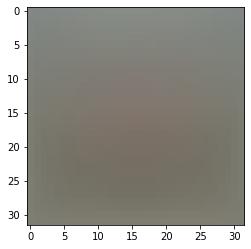

In [203]:
#The first thing we need to do is implement a function to handle our data preprocessing.
#For now, we'll just do two things - we'll move our reshaping of the data into an array
#here (it was in the data loading in the last assignment), and we'll
#add a zero shift.   I also added an option to visualize the mean image for this
#cell's example.  Note the mean image is only based on our training data -
#this is reflective of a "real world" case where we wouldn't have access to 
#the testing data at training time.
def preProcessing(train, test, arrayReshape=True, zeroShift=True, zeroShiftVis = True):
    if(zeroShift == True):
        #First, we're going to calculate the overall mean image across our training dataset.
        mean_image = np.average(train, axis=0)
        if(zeroShiftVis == True):
            plt.figure(figsize=(4,4))
            plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) 
            plt.show()
        #And - we subtract!  That's all there is to this.
        train -= mean_image
        test -= mean_image

    if(arrayReshape == True):
        #Here, we're reshaping CIFAR-10 from 32x32 to a 1x3024 array.
        #We are moving this into preprocessing, as once we get to 
        #convolutional nets, we won't want to do this anymore.
        train = np.reshape(train, (train.shape[0], -1))
        test = np.reshape(test, (test.shape[0], -1))

    return(train, test)

#Note the .copy() where we call the below funciton.
#You'll start seeing this more in the code - this instructs
#python to make a physical copy of labData in memory.
#If you don't do this, labData is treated as equivalent to train and
#test in memory, and thus will update when you run the process.
#This is referred to as a "Deep copy".  To understand this process,
#I recommend you temporarily remove the .copy() and look at how the
#image output changes if you run this cell more than once.
X_train, X_test = preProcessing(train = labData["X_train"].copy(), 
                                test = labData["X_test"].copy(),
                                arrayReshape = True,
                                zeroShift = True,
                                zeroShiftVis = True)




In [204]:
#Next, we need to define a layer of our network.
#To date in lecture - and in this assignment - 
#we've been dealing with fully connected layers.
#That is, if you have an input of CIFAR 10 (3072 pixels),
#and 50 hidden nodes, the total number of weights is equal to
#3072 * 50 (153,600) - i.e., every single input is connected
#to every single hidden node by a weight.  Outputs (i.e., what goes 
#into the hidden nodes) are defined by the dot product between the inputs 
#(CIFAR-10 pixels) and the weights.
#This is also referred to as an "Affine" layer.

#So, let's implement the logic of what happens during an affine layer
#in the forward pass procedure.
#Note that for the first time we'll be including a bias term - b.
#In practice, fully connected (or affine) layers are defined by 
#dot(x, w) + b, where b is a constant bias term.  This bias term
#practically allows your network to have more flexibility in
#'biasing' towards certain solutions, which can be helpful in
#many cases.  We won't go into too much detail on this, but you
#can think back to your elementary statistics course.  When we
#fit a line, it's generally of the form y = mx + b, where b represents
#the constant / y - intercept.  The same concept is applied here.

def affineForward(X, W, B):
    #Total number of observations:
    N = X.shape[0]
    
    #Number of dimensions - in this example, 3072 (i.e., each observation has 3072 values)
    D = np.prod(X.shape[1:])
    
    #Reshape our inputs to be (N,D), matching our expectation for the weights dot product.
    xReshape = np.reshape(X, (N, D))
    
    #Calculate the dot product:
    out = np.dot(xReshape, W) + B

    #Save a cache for use later in the backprop:
    cache = (X, W, B)

    return(out, cache)


#We can run our CIFAR-10 data through this forward pass - here's a quick example
#with the first two.
#I encourage you to check out the shapes of W, B, and X to better understand what's going on.
W = np.random.randn(3072, 50) / np.sqrt(3072/2)
B = np.random.randn(50) / np.sqrt(50/2)

exampleAffineOutA, exampleAffineCacheA = affineForward(X_train[0:2], W, B)

print(exampleAffineOutA)


[[  -4.90591774   12.24254123   -1.6801487    16.65395799  -57.73796315
    11.19363272  -30.54325011  -20.69502448 -120.25470599  -27.61058489
    38.0115244   -73.73874205    6.23220141  -63.82063941 -125.01459386
   -69.88607818   59.14714874   92.63714335  -36.2328846    13.11797575
   -35.57740618   47.49684758   86.10986988  -28.93507006  121.88707987
   183.47470905    9.34691226  -28.96915763   44.1010474    96.88605415
    18.93375649 -134.69392698  -74.19241144   35.6025262    70.74189396
    57.76901144  -83.59821228   98.21344863  -84.6395241   -79.77912473
   -59.11296698 -103.59641924   -8.05710545   28.1401273  -149.84013545
   163.81703822  -11.96327602  -60.96993982   66.87114649  -49.03041578]
 [ 103.64640869   43.1338977   -37.74776336 -138.37651605  -89.00555333
    -9.09212736  142.61964688   22.63291832   98.01539483   86.15028992
    56.93926936  116.53151741   36.6485442   159.9396455    86.2371603
   -50.82635348  -36.38951013   24.37372695  100.31490117   86.1

In [208]:
#Following the example in lecture, the next stage is to pass our outputs 
#Through our activations.  In this case, we'll be using ReLU.
def reluForward(reluInput):
    out = np.maximum(reluInput, 0)
    cache = reluInput
    return(out, cache)

exampleReluOut, exampleReluCache = reluForward(exampleAffineOutA)
print(exampleReluOut[0])

[  0.          12.24254123   0.          16.65395799   0.
  11.19363272   0.           0.           0.           0.
  38.0115244    0.           6.23220141   0.           0.
   0.          59.14714874  92.63714335   0.          13.11797575
   0.          47.49684758  86.10986988   0.         121.88707987
 183.47470905   9.34691226   0.          44.1010474   96.88605415
  18.93375649   0.           0.          35.6025262   70.74189396
  57.76901144   0.          98.21344863   0.           0.
   0.           0.           0.          28.1401273    0.
 163.81703822   0.           0.          66.87114649   0.        ]


In [209]:
#To follow the lecture 10 process, we'll apply the affine net one more time, to replicate
# a two layer net.

#Now, our weights are 50 x 10 - i.e., we have 50 input hidden nodes, and 10 final score nodes.
#The bias matrix also shrinks down to 10 (from 50) - one bias for each output.
W2 = np.random.randn(50, 10) / np.sqrt(50/2)
B2 = np.random.randn(10) / np.sqrt(10/2)

exampleAffineOutB, exampleAffineCacheB = affineForward(exampleReluOut, W2, B2)

#These are the final scores for the forward pass - 10 for each row.
print(exampleAffineOutB)

[[   3.43633513   14.04668519  -59.43988992   80.10756541 -103.88391532
   -38.97405769  -77.69850393   29.48006239   18.22580956   13.73787108]
 [  28.34679977 -164.51984761   19.01618792  294.85322925  -69.38273182
    14.6497417   -60.5064468   100.37577717   46.88305262   59.60640603]]


In [210]:
#Now we need to pass the 10 scores we solve for to our loss function.
#In this function we'll calculate both our loss as well as the 
#gradient with respect to our incoming values.

def svmLoss(y, estimatedScores, e):
    N = estimatedScores.shape[0]

    #This takes the estimated score for the correct class, y.
    #correctClassScore will have one entry per observation.
    correctClassScore = estimatedScores[np.arange(N), y]

    #Now we calculate SVM loss, adding a new dimension to correctClassScore.
    margin = np.maximum(0, estimatedScores-correctClassScore[:,np.newaxis] + e)

    #Set our correct cases to 0 as per the SVM Loss function:
    margin[np.arange(N), y] = 0

    #Calculate the total loss
    loss = np.sum(margin)

    #Now we want to solve for our gradients.
    #Because SVM loss only changes if the value is greater than 0,
    #first we need to identify those cases.
    positiveCount = np.sum(margin>0, axis=1)

    #Now let's solve for dx - first create an empty matrix
    #the same size as our inputs (estimatedScores).
    dx = np.zeros_like(estimatedScores)

    #Identify each case with a postiive value
    dx[margin > 0] = 1

    #Because the true cases result in a negative change, we subtract
    #the total positive cases from the y entries:
    dx[np.arange(N), y] -= positiveCount
    
    #And, finally, divide by our sample size
    dx /= N

    return loss, dx

loss, gradient = svmLoss(y = y_train[0:2], estimatedScores = exampleAffineOutB, e = 1.0)
print(loss)
print(gradient)


968.2246069391364
[[ 0.5  0.5  0.5  0.5  0.   0.5 -4.   0.5  0.5  0.5]
 [ 0.   0.   0.   0.5  0.   0.   0.   0.5  0.  -1. ]]


In [213]:
#Now we're ready for a backwards pass.  
def affineBackward(dUpstream, cache):
    X, W, B = cache
    
    #Same steps as the forward pass:
    N = X.shape[0]
    D = np.prod(X.shape[1:])
    xReshape = np.reshape(X, (N, D))
    
    #Gradient calculations for the affine case - nothing you haven't
    #seen before!
    dx = np.reshape(np.dot(dUpstream, W.T), X.shape) 
    dw = np.dot(xReshape.T, dUpstream) 
    db = np.dot(dUpstream.T, np.ones(N)) 

    return(dx, dw, db)

#Here, dx is the gradient for h (our inputs into this affine);
#dw is the gradient for W,
#db is the gradient for the bias term in the affine.
#The "b" prefix is just to indicate this is the set of gradients
#from the second affine in our network.
b_dx, b_dw, b_db = affineBackward(gradient, exampleAffineCacheB)

#Note that if you initialize weights randomly - instead of with He
#you'll see the gradient decay and saturation in action on these gradients.
#Most of the time, dw[0] will be equal to all 0s!
print(dx[0])
print(dw[0])
print(db[0])

[-0.11282879  0.14643656  0.79115998  0.21459815  0.43959615  0.66586288
  0.09406074 -0.27023692 -0.47597321 -0.72509195  0.09182375  0.5871272
  0.76478279  0.18463825  0.30961783 -0.64321603 -0.48181167 -0.0538147
  0.98957133  1.78042645  0.53548426 -0.16145957  0.20065888  0.14116045
  0.45572161  0.62687847  0.20669583 -1.88647338  0.64409995  0.30779447
  0.23775306 -1.33515814  0.67431192 -0.3837569  -0.60862883  0.04450386
 -1.1952434   0.4647366   0.25419886  0.6580817   1.35424019  0.38969897
 -0.54658089  1.37577244  0.65787111  0.14492441 -1.26580148  0.08871381
  0.46599225 -0.31207321]
[   0.            0.            0.           51.82320435    0.
    0.            0.           51.82320435    0.         -103.64640869]
0.5


In [218]:
#Alright, now we head backwards through the ReLu!
def reluBackward(upstreamGradient, cache):
    x = cache

    #Remember this gradient is just copying our incoming,
    #and then setting anything less than 0 to 0!
    dx = np.array(upstreamGradient, copy=True)
    dx[x <= 0] = 0

    return(dx)

reluBackGradient = reluBackward(b_dx, exampleReluCache)

(2, 50)
(50, 10)


In [222]:
#And through the final affine...
a_dx, a_dw, a_db = affineBackward(reluBackGradient, exampleAffineCacheA)

print(a_dw)
print(a_db)

#And, we're done!  We now have everything we would need to update our weights:
#W in the first layer is updated by a_dw
#Our bias in the first layer is updated by a_db
#Our W in the second layer is updated by b_dw
#Our bias in the second layer is updated by b_db
#Once we update, we can repeat the entire process -
#But, now it's very easy to swap pieces of that process in and out.
#In the next section, we're going to put all of these pieces
#together.

[[  5.77846628  -5.52427057   0.         ...   0.         -33.41664935
   -3.19140043]
 [ 10.15887642  -2.09501945   0.         ...   0.         -34.50958758
   -5.6106657 ]
 [ 13.50903938   1.44967308   0.         ...   0.         -32.41153202
   -7.46093375]
 ...
 [  4.05942587   2.96335586   0.         ...   0.          -1.69578309
   -2.24198824]
 [  1.77396364  -3.42906474   0.         ...   0.         -15.77397759
   -0.97974584]
 [  7.34877034   0.12300096   0.         ...   0.         -19.74961846
   -4.05866673]]
[ 0.24811721  0.36013176  0.          0.21459815  0.          0.66586288
 -0.09677854 -0.35756535  0.18493582  0.44219147  0.04203756  0.09298704
  1.25442603  0.27280887 -0.12553162  0.         -0.48181167 -0.17235108
  0.21609541  1.44494277  0.         -0.16145957  0.29501763  0.
  0.5242007   0.45900123  0.81776416  0.          0.64409995  0.09040913
  0.28484575  0.         -0.07304672 -0.17699938 -0.60862883  0.04450386
  0.          0.37444815  0.12780198 -0.18